In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import spacy
from pprint import pprint

In [2]:
data = pd.read_csv("data/BA_reviews.csv")

In [3]:
data.head(4)

,Unnamed: 0,reviews
0,0,Not Verified | Happy with the flight crew. Ha...
1,1,✅ Trip Verified | Horrible service from boar...
2,2,Not Verified | My wife and I are very disappo...
3,3,Not Verified | We flew BA between Heathrow an...


In [4]:
data.drop(columns='Unnamed: 0', inplace=True)

In [5]:
data.head()

,reviews
0,Not Verified | Happy with the flight crew. Ha...
1,✅ Trip Verified | Horrible service from boar...
2,Not Verified | My wife and I are very disappo...
3,Not Verified | We flew BA between Heathrow an...
4,Not Verified | Absolutely disgusted with BA. ...


In [6]:
# clean the reviews column, validation from the text
data.reviews = data.reviews.str.split("|", expand=True).get(1)

In [7]:
data.head()

,reviews
0,Happy with the flight crew. Hadn't been on a...
1,Horrible service from boarding to landing. ...
2,My wife and I are very disappointed with fly...
3,We flew BA between Heathrow and Berlin one w...
4,Absolutely disgusted with BA. Our flights we...


##### Preprocess the review column for natural language processing


In [8]:
import nltk 
from nltk.corpus import stopwords
import re 


In [9]:
# download the stopwords 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /home/ksilas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ksilas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/ksilas/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [10]:
# text preprocessing function
def preprocess(text):
    # Remove special characters and digits
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)  # Remove single characters from start
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Replace multiple spaces with a single space
    text = text.lower()  # Lowercase text
    tokens = nltk.word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

In [11]:
# apply the text preprocessing function to the reviews dataset
data['processed_reviews'] = data.reviews.apply(preprocess)
data_words = data.processed_reviews.values.tolist()
data_words[:1]

[['happy',
  'flight',
  'crew',
  'plane',
  '20',
  'years',
  'stressed',
  'made',
  'comfortable',
  'want',
  'say',
  'thank',
  'flight',
  'crew',
  'helping',
  'relax',
  'go',
  'back',
  'france',
  'going',
  'british',
  'airways']]

In [12]:
#  Build the Bigram, Trigram Models and Lemmatize

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [17]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [19]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [23]:
# build LDA model 


# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)


In [27]:
pprint(lda_model.print_topics())

[(0,
  '0.026*"passenger" + 0.025*"drink" + 0.022*"meal" + 0.018*"crew" + '
  '0.017*"lounge" + 0.016*"serve" + 0.015*"take" + 0.014*"time" + '
  '0.013*"cabin" + 0.013*"seem"'),
 (1,
  '0.044*"flight" + 0.020*"get" + 0.017*"ba" + 0.015*"go" + 0.014*"hour" + '
  '0.014*"check" + 0.014*"customer" + 0.013*"tell" + 0.011*"make" + '
  '0.011*"back"'),
 (2,
  '0.024*"charge" + 0.020*"many" + 0.014*"high" + 0.013*"make" + 0.012*"less" '
  '+ 0.011*"want" + 0.011*"couple" + 0.011*"possible" + 0.010*"future" + '
  '0.009*"card"'),
 (3,
  '0.047*"seat" + 0.028*"flight" + 0.021*"food" + 0.019*"good" + 0.018*"class" '
  '+ 0.017*"economy" + 0.016*"business" + 0.016*"fly" + 0.016*"service" + '
  '0.015*"airline"')]


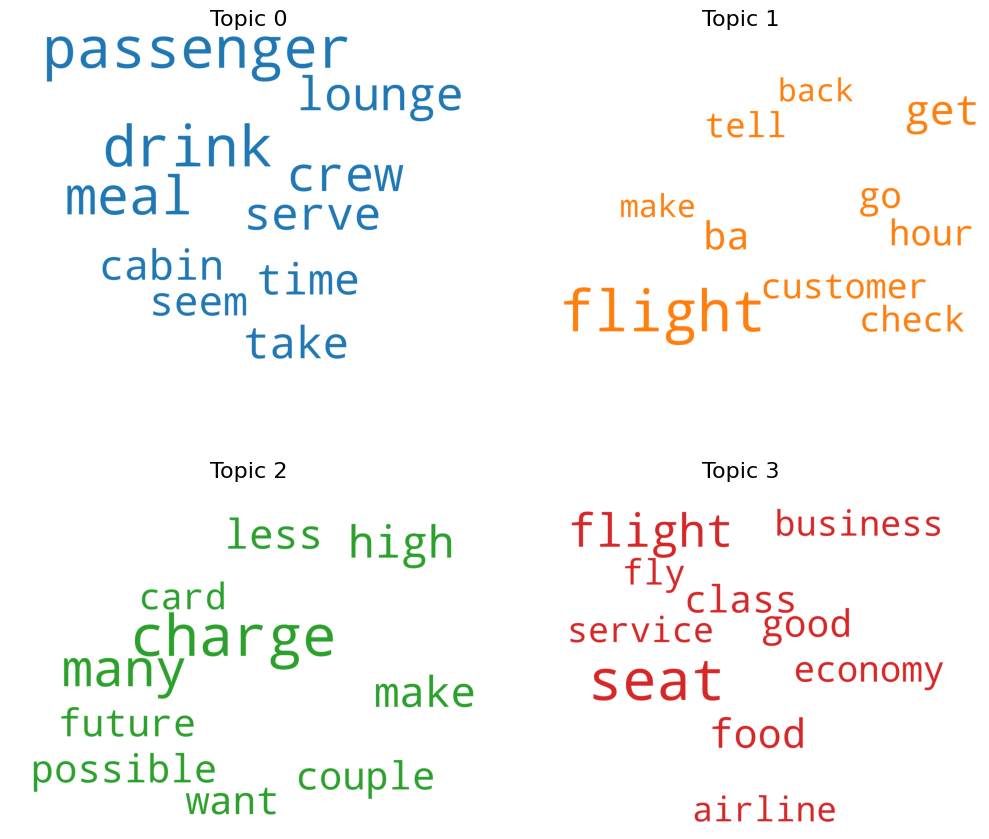

In [30]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

/tmp/ipykernel_22917/3551799154.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_22917/3551799154.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_22917/3551799154.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_22917/3551799154.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 

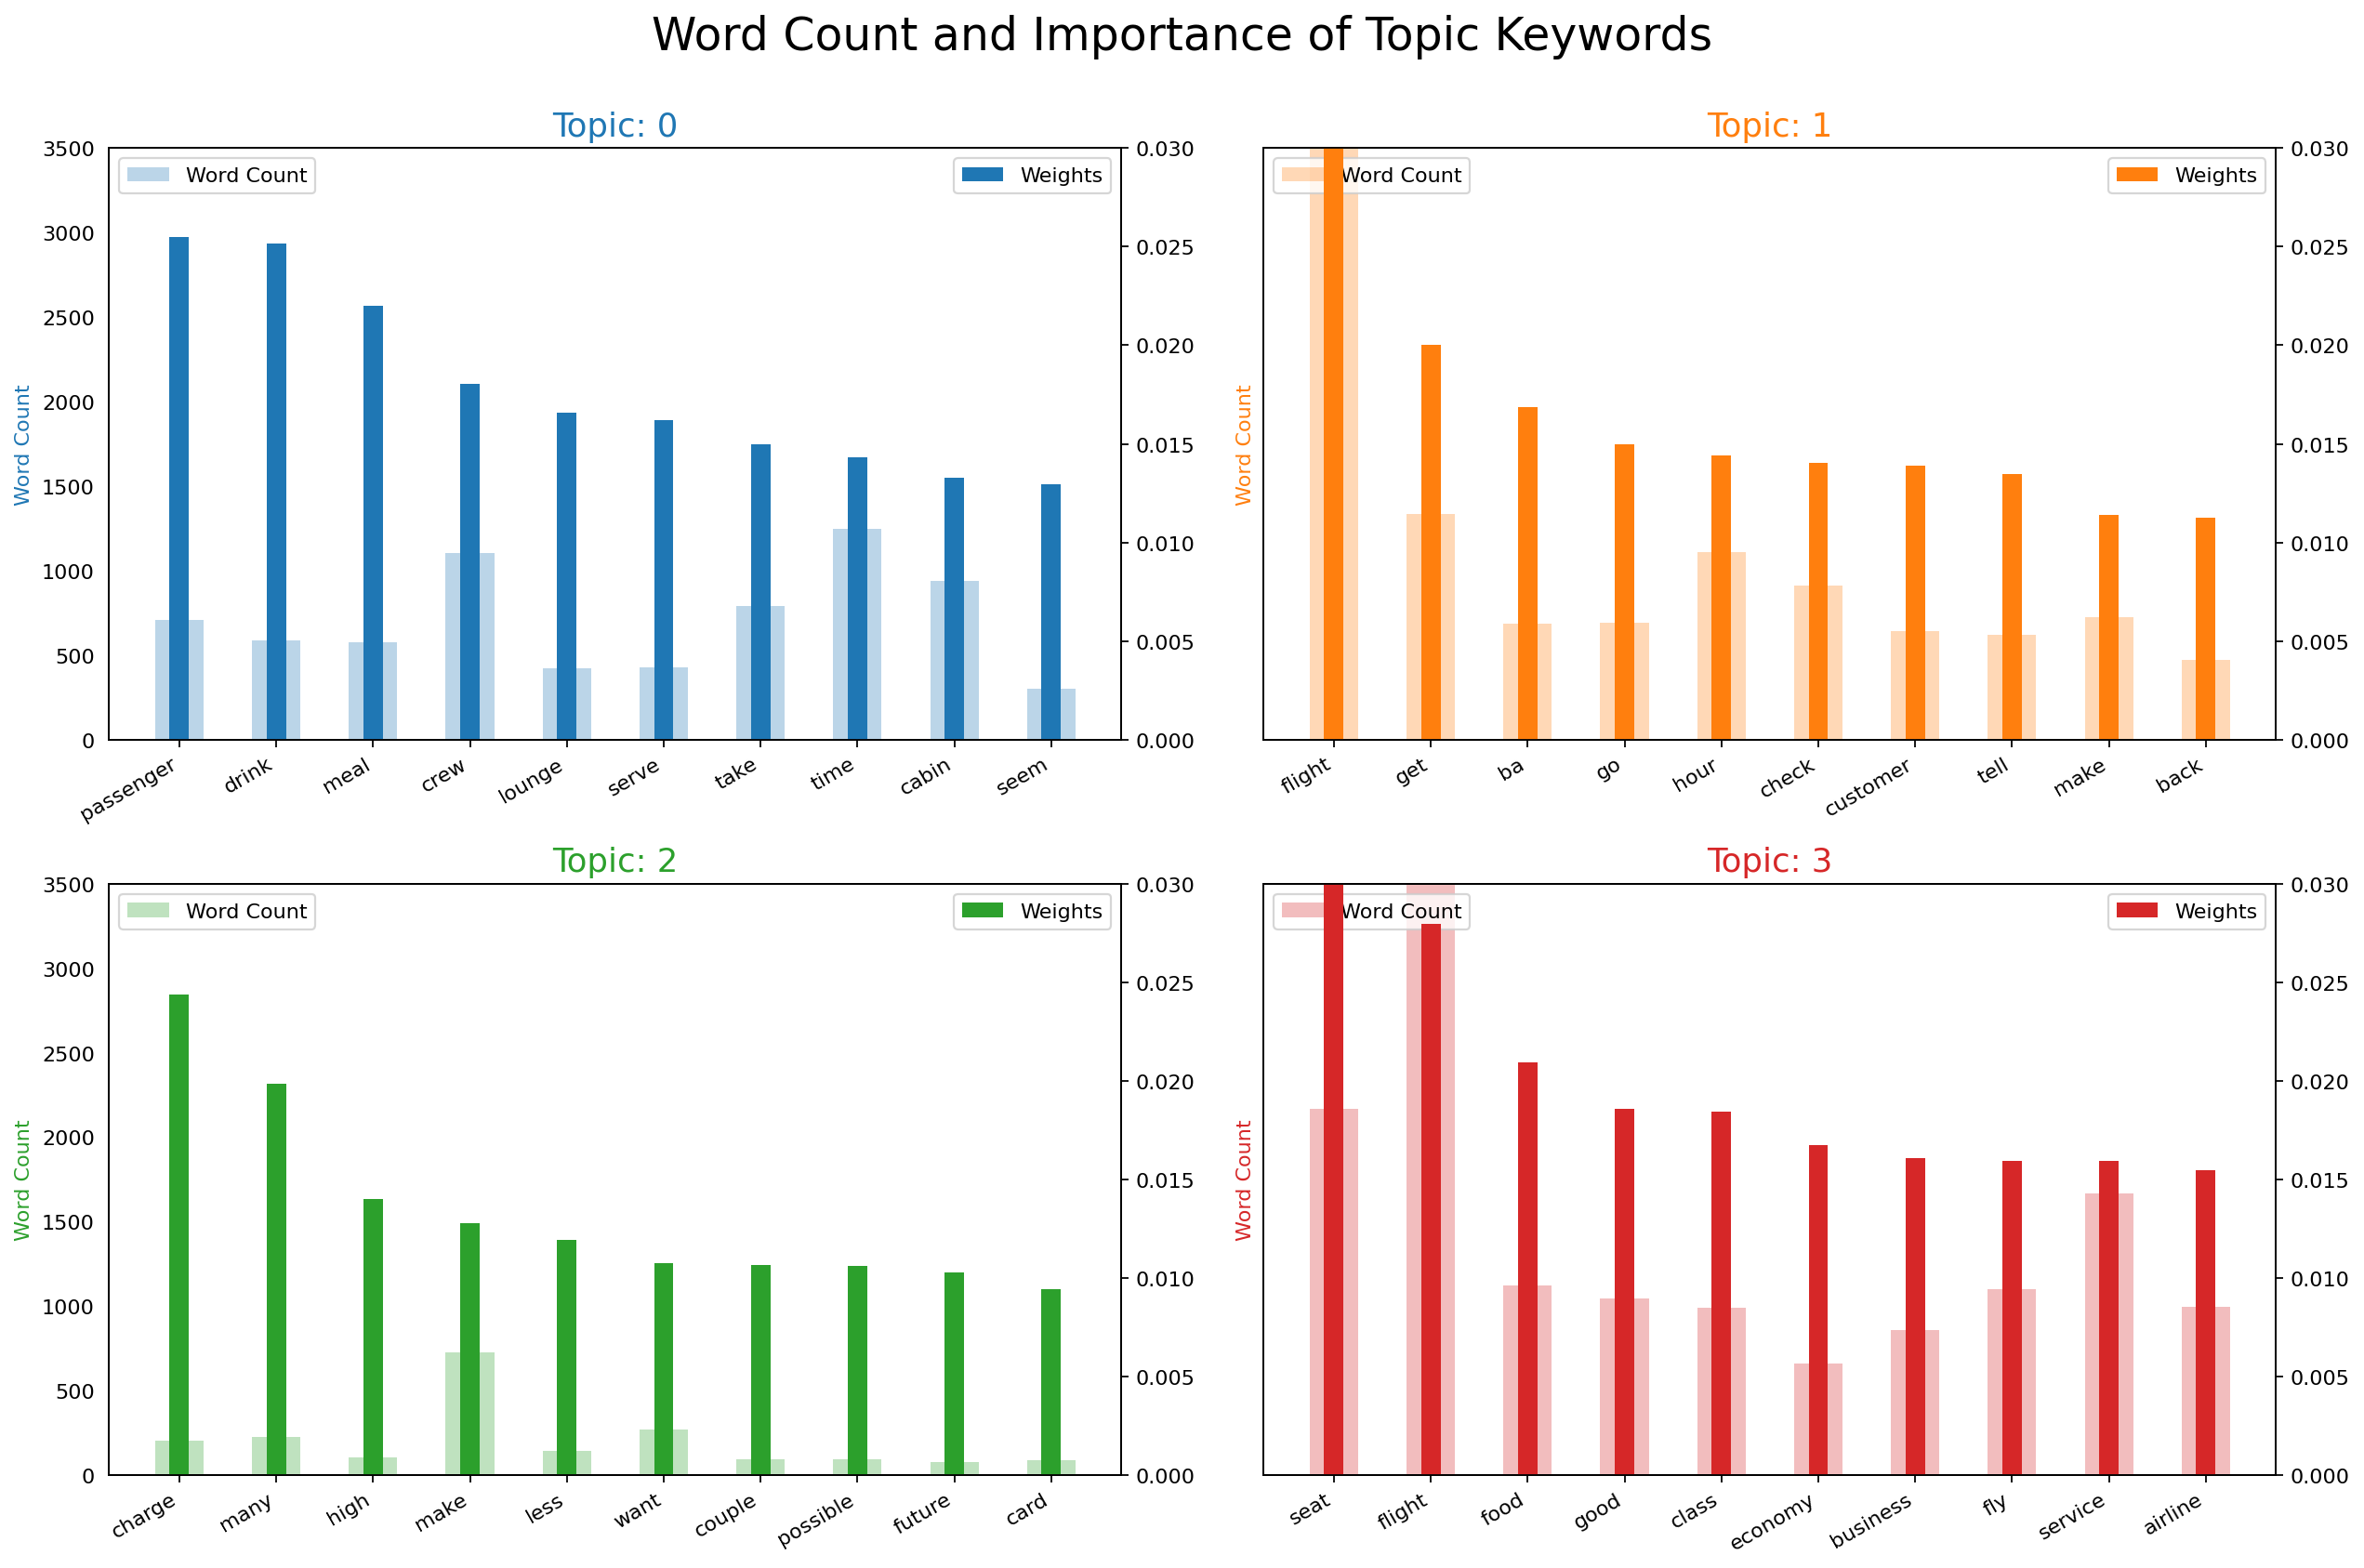

In [31]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()


In [33]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.133752  0.105225       1        1  39.689112
3     -0.199633  0.087389       2        1  33.154221
0      0.020539 -0.313979       3        1  19.623071
2      0.312845  0.121365       4        1   7.533596, topic_info=          Term         Freq        Total Category  logprob  loglift
27        seat  2118.000000  2118.000000  Default  30.0000  30.0000
148  passenger   687.000000   687.000000  Default  29.0000  29.0000
328      drink   677.000000   677.000000  Default  28.0000  28.0000
141       meal   595.000000   595.000000  Default  27.0000  27.0000
67        good   846.000000   846.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
7         make   132.182895   752.426585   Topic4  -4.3594   0.8467
478        see    85.202916   255.869223   Topic4  -4.7986   1.4862
450     travel    76.052001   355.798701   Topic4  -4.9122   1.0428
399        put    63.806433   213.605435   Topic4  -5.0878   1.3775
44        wife    58.565028   150.244218   Topic4  -5.1735   1.6437

[213 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
481       4  0.995527   advance
46        2  0.998292  aircraft
35        1  0.446361   airline
35        2  0.541955   airline
35        4  0.010793   airline
...     ...       ...       ...
426       1  0.991363     whole
426       4  0.006196     whole
44        1  0.266233      wife
44        2  0.339447      wife
44        4  0.392694      wife

[219 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])